### What is this notebook trying to answer?
1. **Is perp "basis" predictable?** Funding rate is treated as a proxy for basis (premium/discount vs spot). If funding is persistent ("sticky"), basis is persistent.
1. **If it’s predictable, can you harvest it with a simple strategy?** Strategy = long spot + short perp for the coins where you expect positive funding (i.e., shorts receive funding), rotated daily into the strongest candidates.
1. **What part of PnL drives the returns?** They decompose PnL into: spot/perp price moves (basis change), funding earned, trading costs

### Load perpetual funding rate history

In [1]:
# Import and preprocess data

import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress
import numpy as np

# Load the funding rate data from CSV
df_funding = pd.read_csv('binance_funding_rate_history.csv')

# Convert funding_time to datetime
df_funding['funding_time'] = pd.to_datetime(df_funding['funding_time'])

# Convert funding_rate and mark_price to numeric
df_funding['funding_rate'] = pd.to_numeric(df_funding['funding_rate'])
df_funding['mark_price'] = pd.to_numeric(df_funding['mark_price'])

# Create a dictionary of dataframes, one per symbol
df_by_symbol = {
    symbol: df_funding[df_funding['symbol'] == symbol].copy() 
    for symbol in df_funding['symbol'].unique()
}

# Resample to daily frequency (aggregate funding rates per day)
df_daily_list = []
for symbol, df in df_by_symbol.items():
    df_daily = (df.set_index('funding_time')
                  .resample('D')['funding_rate']
                  .sum()
                  .to_frame())
    df_daily['symbol'] = symbol
    df_daily_list.append(df_daily)

# Combine all symbols into one dataframe
df_daily = pd.concat(df_daily_list)

# Pivot to wide format for easier analysis
df_daily_wide = (df_daily.reset_index()
                         .pivot(index='funding_time', 
                                columns='symbol', 
                                values='funding_rate'))


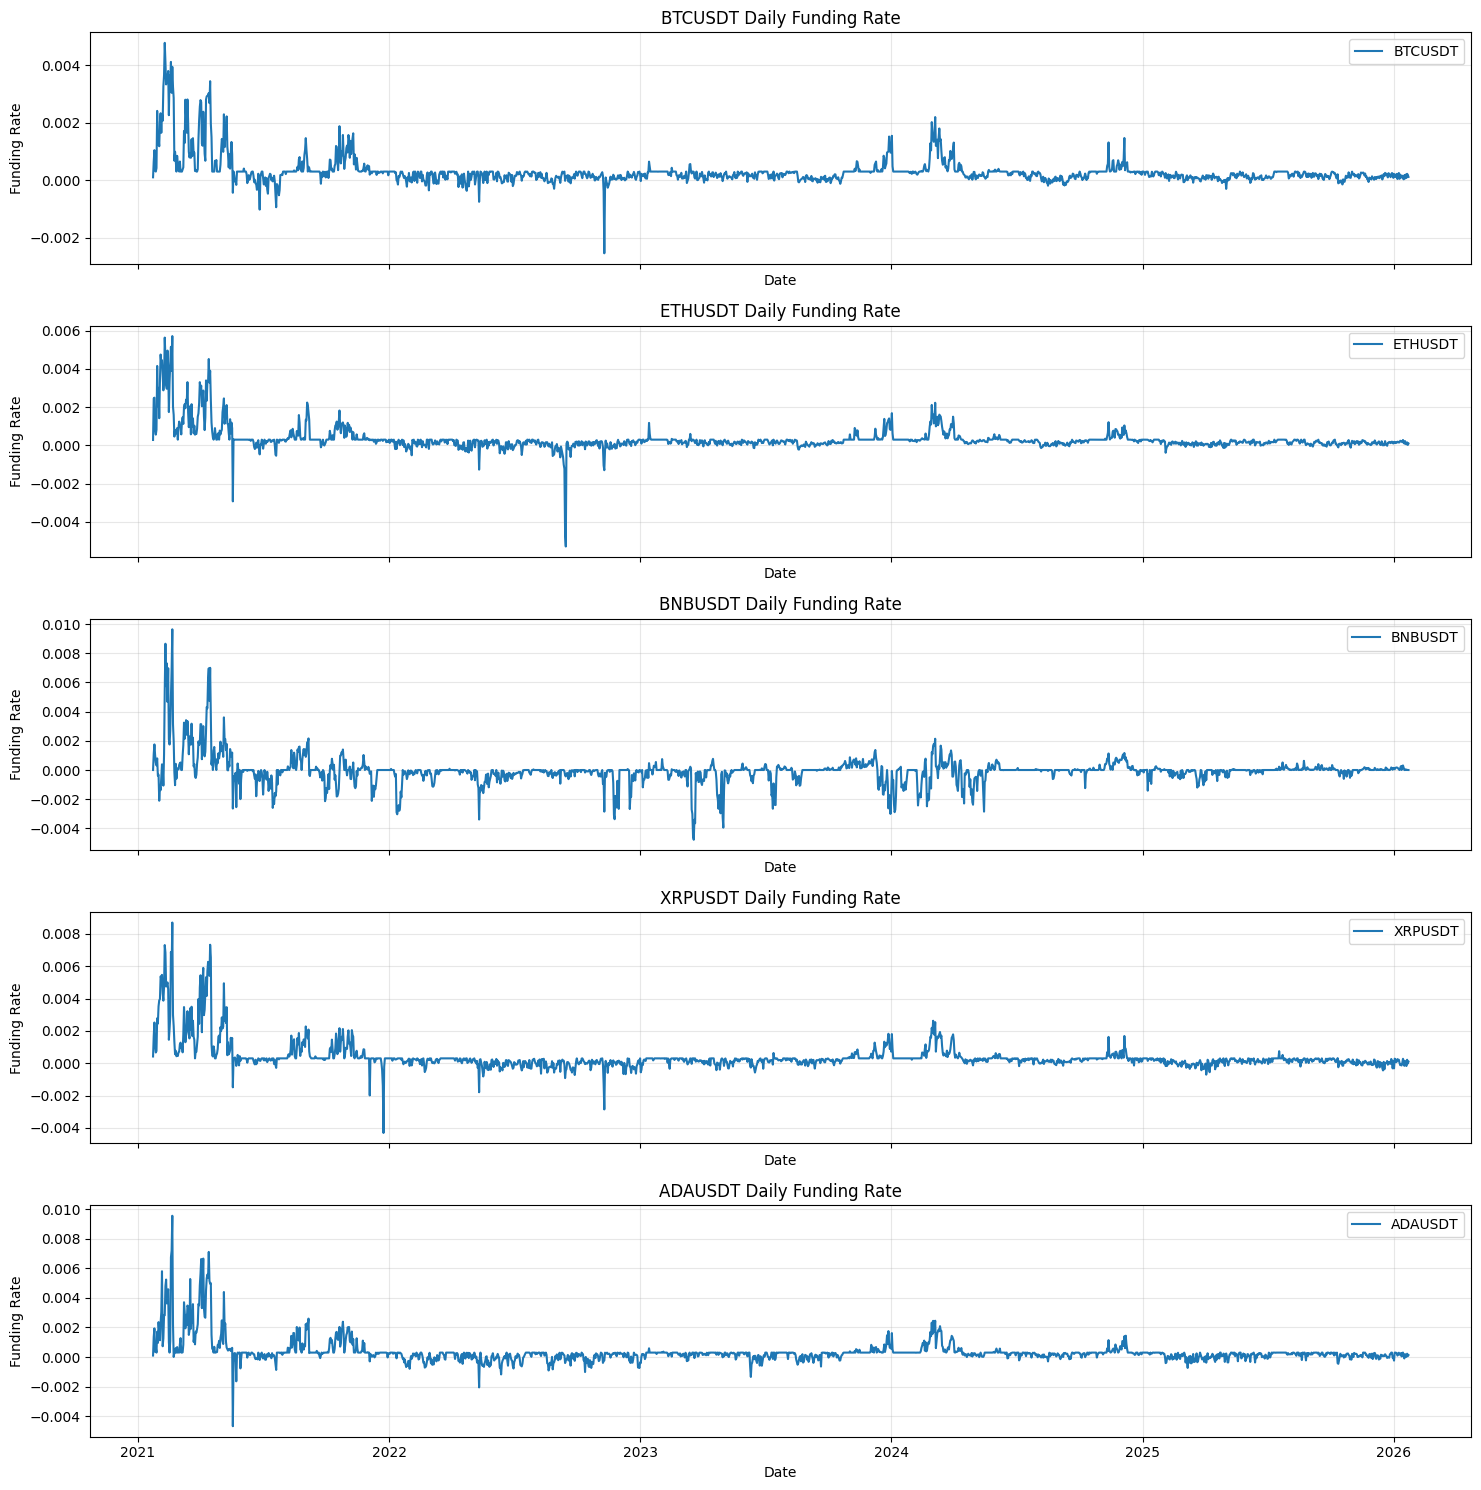

In [2]:
# Plot a couple of symbol's daily funding rate separately

symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT']

fig, axes = plt.subplots(len(symbols), 1, figsize=(15, 3 * len(symbols)), sharex=True)

for idx, symbol in enumerate(symbols):
    axes[idx].plot(df_daily_wide.index, df_daily_wide[symbol], label=symbol)
    axes[idx].set_title(f'{symbol} Daily Funding Rate')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Funding Rate')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Testing basis predictability using ACF/PACF on funding

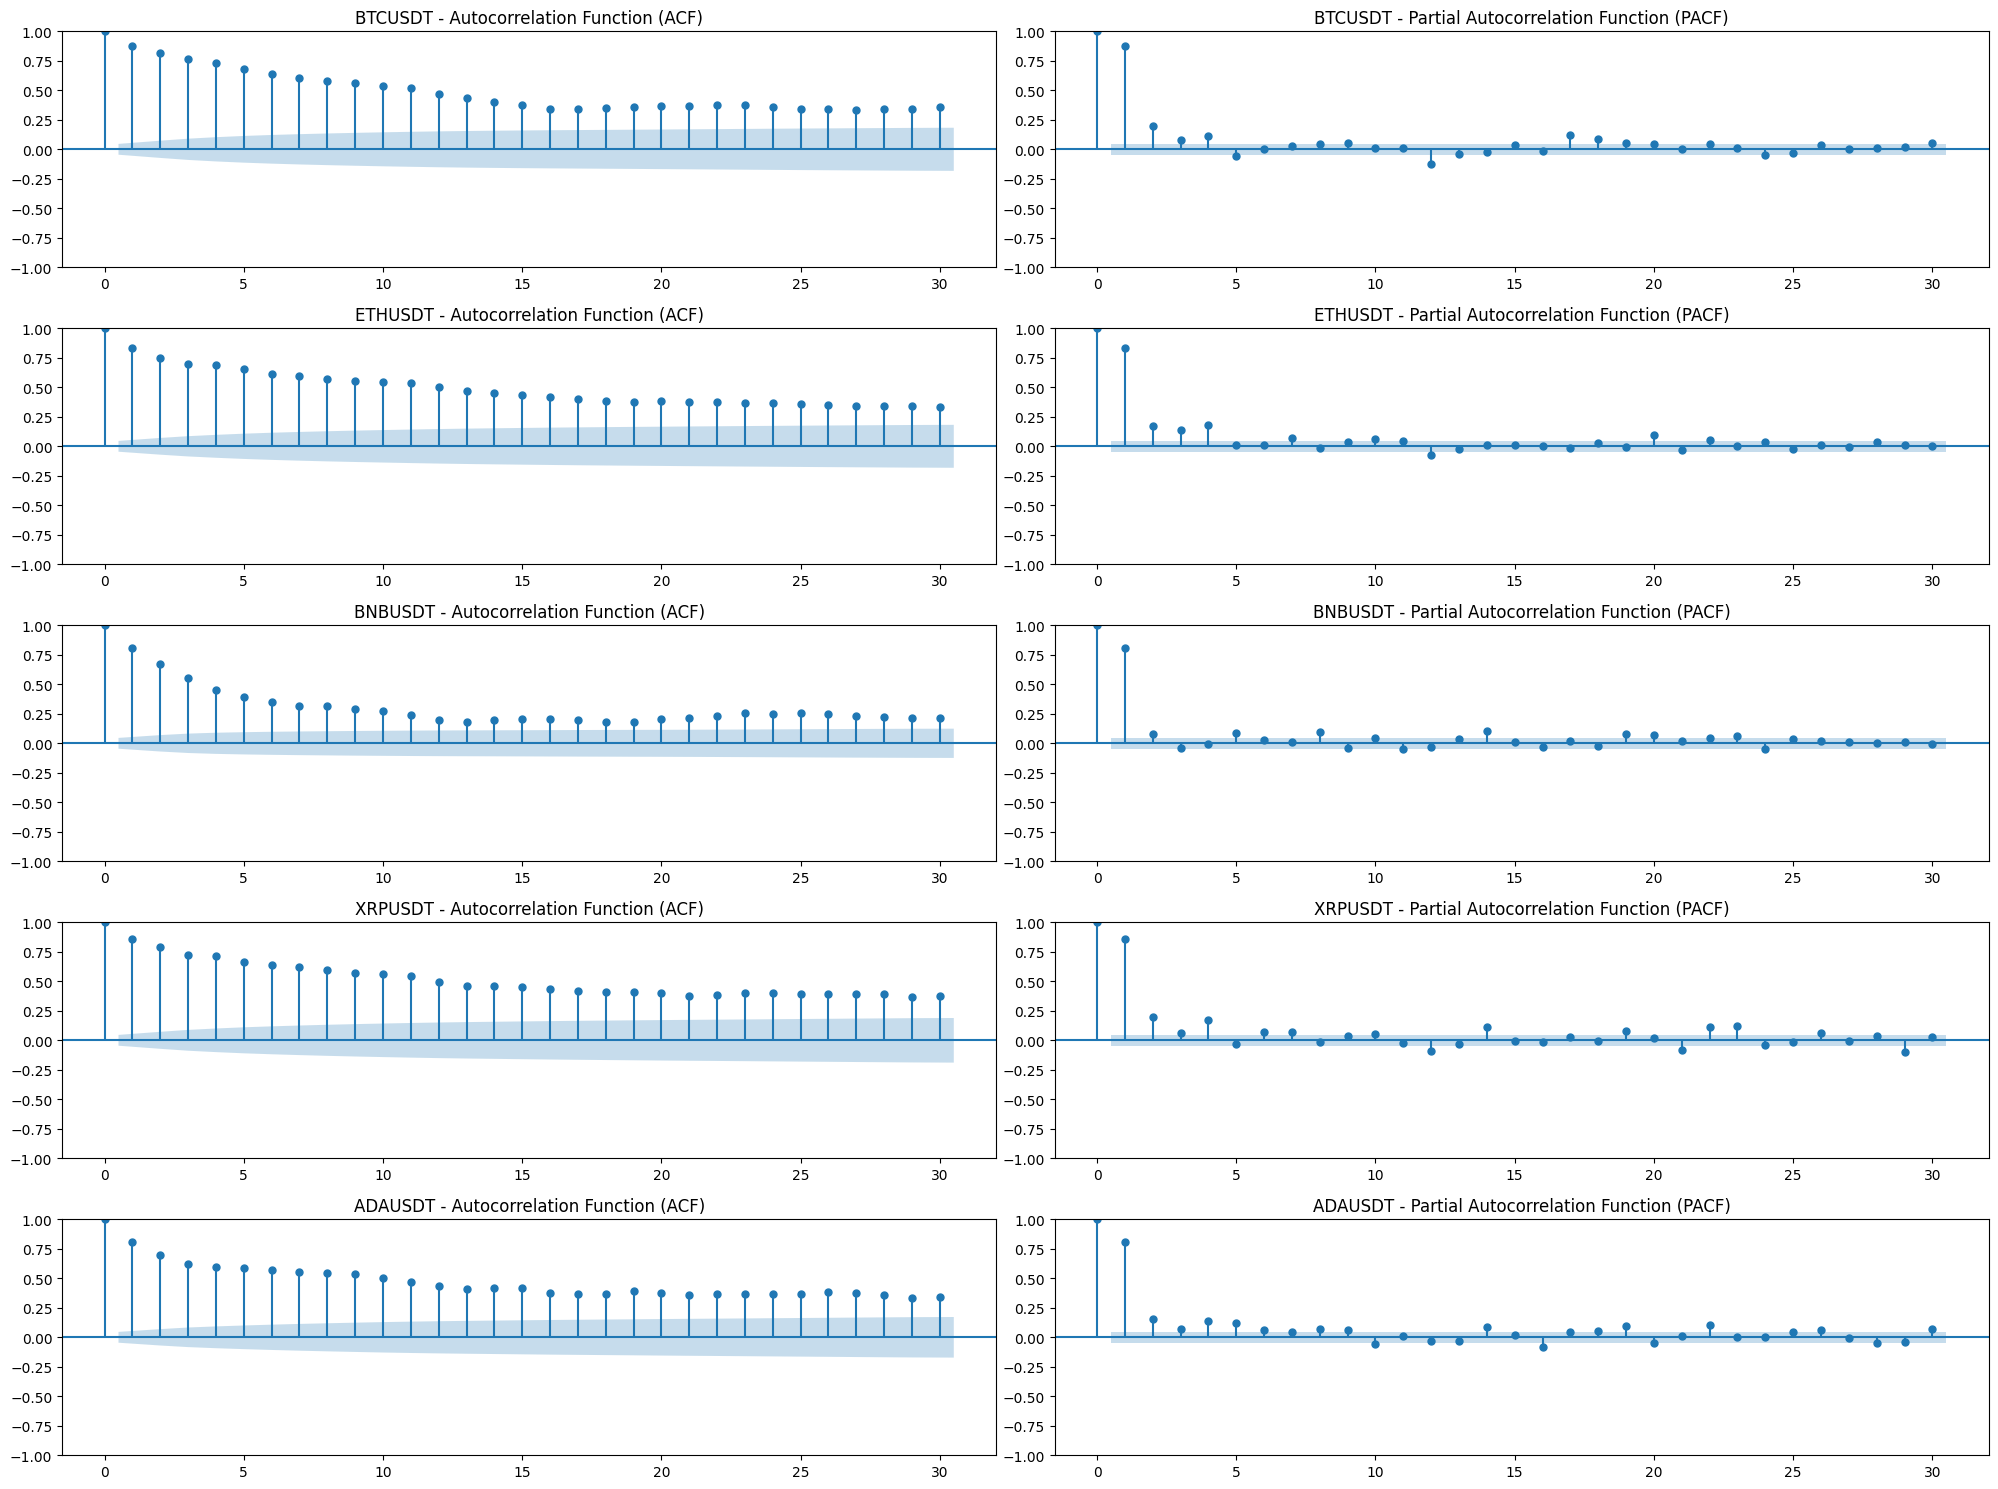

In [3]:
# Create subplots for ACF and PACF for each symbol

fig, axes = plt.subplots(len(symbols), 2, figsize=(20, 3 * len(symbols)))

for idx, symbol in enumerate(symbols):
    # Plot ACF
    plot_acf(df_daily_wide[symbol].dropna(), lags=30, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{symbol} - Autocorrelation Function (ACF)')
    
    # Plot PACF
    plot_pacf(df_daily_wide[symbol].dropna(), lags=30, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{symbol} - Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### Estimating break-even holding horizon

**Logic**: To profit from funding rate arbitrage, the cumulative funding earned must exceed round-trip trading costs. The break-even holding period is approximately:

$$\text{Holding Period (days)} \approx \frac{\text{Round-trip Trading Cost (\%)}}{\text{Average Daily Funding Rate (\%)}}$$

**Binance Spot Trading Costs** (assuming VIP 0):
- Maker: 0.1% per side → **0.2% round-trip**
- Taker: 0.1% per side → **0.2% round-trip**

**Binance Futures Trading Costs** (assuming VIP 0):
- Maker: 0.02% per side → **0.04% round-trip**
- Taker: 0.05% per side → **0.10% round-trip**

We'll consider the worst case scenario, which amounts to **0.2%** for two spot transactions and **0.10%** for two futures transactions, together **0.30%**.

In [4]:
# Calculate average funding rate for each symbol
avg_funding_by_symbol = df_daily_wide.mean()

# Filter only negative average funding rates
negative_avg_funding = avg_funding_by_symbol[avg_funding_by_symbol < 0]

# Calculate the overall average of negative funding rates
overall_avg_negative = negative_avg_funding.mean()

print(f"Number of symbols with negative average funding: {len(negative_avg_funding)}")
print(f"Overall average of negative funding rates: {overall_avg_negative:.6f} ({overall_avg_negative * 100:.4f}%)")

# Calculate break-even holding period for negative funding symbols
round_trip_cost = 0.003  # 0.3%
breakeven_days = round_trip_cost / abs(avg_funding_by_symbol.mean())
breakeven_days_negative = round_trip_cost / abs(overall_avg_negative)

print(f"\nBreak-even holding period:")
print(f"Round-trip trading cost: {round_trip_cost * 100:.2f}%")
print(f"Break-even period (overall avg): {breakeven_days:.2f} days")
print(f"Break-even period (negative funding avg): {breakeven_days_negative:.2f} days")

Number of symbols with negative average funding: 208
Overall average of negative funding rates: -0.001685 (-0.1685%)

Break-even holding period:
Round-trip trading cost: 0.30%
Break-even period (overall avg): 7.18 days
Break-even period (negative funding avg): 1.78 days


### Building a simple funding forecast model

**Goal**: Predict the next 7 days of cumulative funding based on the average funding rate over the last 4 days.

**Model**:
- **Forecast** = 7 × (mean funding over last 4 days)
- **Truth label** = sum of the next 7 daily funding values

**Approach**:
1. For each ticker, compute:
    - `predicted_funding`: 7 × rolling mean of last 4 days
    - `actual_funding`: forward 7-day sum
2. Create scatter plots of predicted vs actual funding
3. Repeat with non-overlapping windows (sample every 7th row) to reduce autocorrelation in the diagnostic plots

**Why remove overlapping windows?**  
Rolling windows create highly correlated data points. Sampling every 7th row gives independent observations for cleaner model diagnostics.

In [8]:
# Build a simple forecast model for each symbol
# Forecast = 7 × (mean funding over last 4 days)
# Actual = sum of next 7 days funding

# We'll create a dataframe to store predictions and actuals
forecast_results = []

for symbol in df_daily_wide.columns:
    # Get the series for this symbol and drop NaN
    series = df_daily_wide[symbol].dropna()
    
    if len(series) < 11:  # Need at least 4 days for lookback + 7 days for forward
        continue
    
    # Calculate rolling mean of last 4 days
    rolling_mean_4d = series.rolling(window=4).mean()
    
    # Calculate forward 7-day sum
    forward_7d_sum = series.rolling(window=7).sum().shift(-7)
    
    # Predicted funding = 7 × rolling mean of last 4 days
    predicted_funding = 7 * rolling_mean_4d
    
    # Create a temporary dataframe
    temp_df = pd.DataFrame({
        'symbol': symbol,
        'date': series.index,
        'predicted_funding': predicted_funding,
        'actual_funding': forward_7d_sum
    })
    
    # Drop rows with NaN (first 3 rows due to rolling, last 6 rows due to shift)
    temp_df = temp_df.dropna()
    
    forecast_results.append(temp_df)

# Combine all results
df_forecast = pd.concat(forecast_results, ignore_index=True)

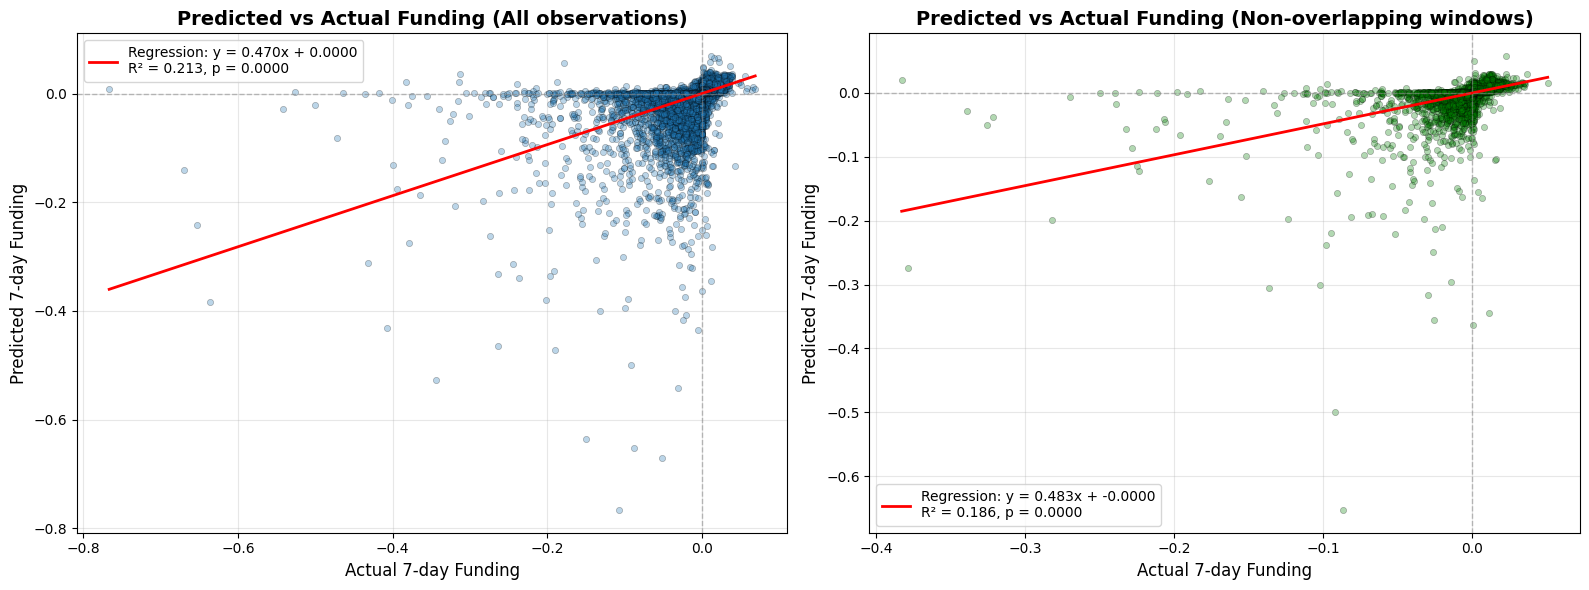


All observations:
  Observations: 370611
  Correlation: 0.4613
  R-squared: 0.2128
  p-value: 0.0000

Non-overlapping windows:
  Observations: 53206
  Correlation: 0.4317
  R-squared: 0.1864
  p-value: 0.0000


In [11]:
# Create scatter plots of predicted vs actual funding

# Overall scatter plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All overlapping data
axes[0].scatter(df_forecast['actual_funding'], df_forecast['predicted_funding'], 
                alpha=0.3, s=20, edgecolors='black', linewidth=0.5)

# Calculate and plot regression line
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(
    df_forecast['actual_funding'], df_forecast['predicted_funding']
)
x_line1 = np.array([df_forecast['actual_funding'].min(), df_forecast['actual_funding'].max()])
y_line1 = slope1 * x_line1 + intercept1
axes[0].plot(x_line1, y_line1, 'r-', linewidth=2, 
            label=f'Regression: y = {slope1:.3f}x + {intercept1:.4f}\nR² = {r_value1**2:.3f}, p = {p_value1:.4f}')

# Add horizontal and vertical lines at zero
axes[0].axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

axes[0].set_xlabel('Actual 7-day Funding', fontsize=12)
axes[0].set_ylabel('Predicted 7-day Funding', fontsize=12)
axes[0].set_title('Predicted vs Actual Funding (All observations)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Non-overlapping windows (sample every 7th row)
df_forecast_sampled = df_forecast.groupby('symbol').apply(lambda x: x.iloc[::7], include_groups=False).reset_index(drop=True)
axes[1].scatter(df_forecast_sampled['actual_funding'], df_forecast_sampled['predicted_funding'], 
                alpha=0.3, s=20, color='green', edgecolors='black', linewidth=0.5)

# Calculate and plot regression line
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(
    df_forecast_sampled['actual_funding'], df_forecast_sampled['predicted_funding']
)
x_line2 = np.array([df_forecast_sampled['actual_funding'].min(), df_forecast_sampled['actual_funding'].max()])
y_line2 = slope2 * x_line2 + intercept2
axes[1].plot(x_line2, y_line2, 'r-', linewidth=2, 
            label=f'Regression: y = {slope2:.3f}x + {intercept2:.4f}\nR² = {r_value2**2:.3f}, p = {p_value2:.4f}')

# Add horizontal and vertical lines at zero
axes[1].axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

axes[1].set_xlabel('Actual 7-day Funding', fontsize=12)
axes[1].set_ylabel('Predicted 7-day Funding', fontsize=12)
axes[1].set_title('Predicted vs Actual Funding (Non-overlapping windows)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAll observations:")
print(f"  Observations: {len(df_forecast)}")
print(f"  Correlation: {r_value1:.4f}")
print(f"  R-squared: {r_value1**2:.4f}")
print(f"  p-value: {p_value1:.4f}")

print(f"\nNon-overlapping windows:")
print(f"  Observations: {len(df_forecast_sampled)}")
print(f"  Correlation: {r_value2:.4f}")
print(f"  R-squared: {r_value2**2:.4f}")
print(f"  p-value: {p_value2:.4f}")

### Load perpetual futures and spot OHLVC data

In [35]:
# Load spot and perpetual OHLCV data
df_spot = pd.read_csv('binance_spot_ohlcv_history.csv')
df_perp = pd.read_csv('binance_perp_ohlcv_history.csv')

# Convert datetime to datetime format
df_spot['datetime'] = pd.to_datetime(df_spot['datetime'])
df_perp['datetime'] = pd.to_datetime(df_perp['datetime'])

# Clean symbol names: remove '/' from spot and '/' + ':USDT' from perp
df_spot['symbol'] = df_spot['symbol'].str.replace('/', '', regex=False)
df_perp['symbol'] = df_perp['symbol'].str.replace('/', '', regex=False).str.replace(':USDT', '', regex=False)

# Select only needed columns
df_spot_clean = df_spot[['datetime', 'symbol', 'close', 'volume']].copy()
df_perp_clean = df_perp[['datetime', 'symbol', 'close', 'volume']].copy()

# Rename columns to distinguish spot and perp
df_spot_clean = df_spot_clean.rename(columns={'close': 'close_spot', 'volume': 'volume_spot'})
df_perp_clean = df_perp_clean.rename(columns={'close': 'close_perp', 'volume': 'volume_perp'})

# Merge on datetime and symbol
df_combined = pd.merge(df_spot_clean, df_perp_clean, on=['datetime', 'symbol'], how='inner')

# Calculate notional volume in USDT for both spot and perp
df_combined['notional_volume_spot'] = df_combined['volume_spot'] * df_combined['close_spot']
df_combined['notional_volume_perp'] = df_combined['volume_perp'] * df_combined['close_perp']

# Calculate average notional volume
df_combined['volume'] = (df_combined['notional_volume_spot'] + df_combined['notional_volume_perp']) / 2

# Calculate 5-day rolling average of volume
df_combined['volume_ma5'] = df_combined.groupby('symbol')['volume'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean())

# Add universe column: True if 5-day average volume > $2M
df_combined['universe'] = df_combined['volume_ma5'] > 2e6

# Select final columns
df_ohlcv = df_combined[['datetime', 'symbol', 'close_spot', 'close_perp', 'volume_ma5', 'universe']].copy()

print(f"Loaded {len(df_ohlcv)} rows across {df_ohlcv['symbol'].nunique()} symbols")
print(f"Date range: {df_ohlcv['datetime'].min()} to {df_ohlcv['datetime'].max()}")
print("\nFirst few rows:")
print(df_ohlcv.head(5))

Loaded 313384 rows across 374 symbols
Date range: 2021-01-23 00:00:00 to 2026-01-22 00:00:00

First few rows:
    datetime   symbol  close_spot  close_perp    volume_ma5  universe
0 2021-01-23  BTCUSDT    32078.00    32086.48  5.155569e+09      True
1 2021-01-24  BTCUSDT    32259.90    32275.63  4.756848e+09      True
2 2021-01-25  BTCUSDT    32254.20    32253.68  5.349367e+09      True
3 2021-01-26  BTCUSDT    32467.77    32474.14  5.764887e+09      True
4 2021-01-27  BTCUSDT    30366.15    30381.04  6.212650e+09      True


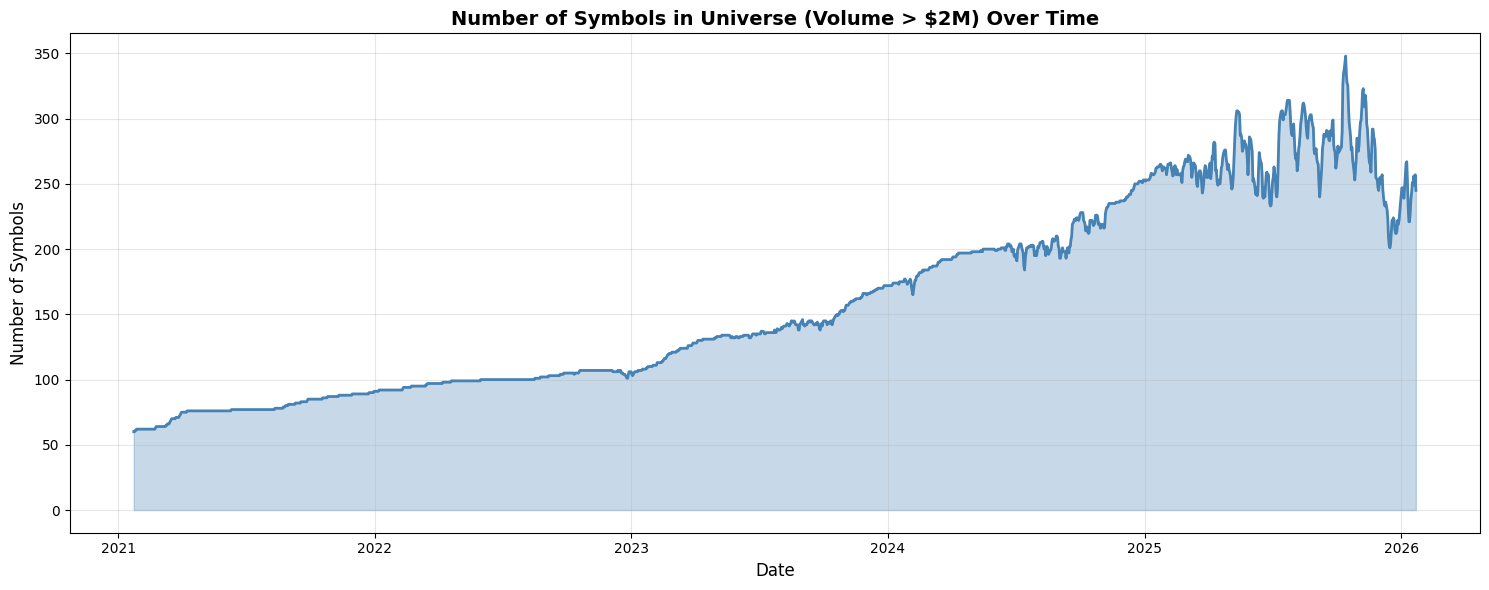

Universe size statistics:
  Min: 60 symbols
  Max: 348 symbols
  Mean: 159.7 symbols
  Median: 137 symbols


In [ ]:
# Count the number of distinct symbols where universe = True for each day
universe_count = df_ohlcv[df_ohlcv['universe'] == True].groupby('datetime')['symbol'].nunique()

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(universe_count.index, universe_count.values, linewidth=2, color='steelblue')
plt.fill_between(universe_count.index, universe_count.values, alpha=0.3, color='steelblue')
plt.title('Number of Symbols in Universe (Volume > $2M) Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Symbols', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()